# Text Analysis on Great Expectations Novel

### Imports- **Run First**

In [1]:
#Bring in text file with our novel
textfile = open('sense_and_sensibility.txt', 'r', encoding = "utf8")
great_expect = textfile.read()

#print(great_expect)

In [2]:
#Import libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

import pandas as pd
from PIL import Image
import numpy as np
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Lowercase words for word cloud
word_cloud_text = great_expect.lower()
#Remove numbers and alphanumeric words we don't need for word cloud
word_cloud_text = re.sub("[^a-zA-Z0-9]", " ", word_cloud_text)

In [4]:
#Tokenize the data to split it into words
tokens = word_tokenize(word_cloud_text)
#Remove stopwords
tokens = (word for word in tokens if word not in stopwords.words('english'))
#Remove short words less than 3 letters in length
tokens = (word for word in tokens if len(word) >= 3)
#Add word cloud stopwords
stopwords_wc = set(stopwords.words("english"))

In [5]:
#Data cleaning to split data into sentences
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"

text = " " + great_expect + "  "
text = text.replace("\n"," ")
text = re.sub(prefixes,"\\1<prd>",text)
text = re.sub(websites,"<prd>\\1",text)
text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
if "..." in text: text = text.replace("...","<prd><prd><prd>")
if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
if "”" in text: text = text.replace(".”","”.")
if "\"" in text: text = text.replace(".\"","\".")
if "!" in text: text = text.replace("!\"","\"!")
if "?" in text: text = text.replace("?\"","\"?")
text = text.replace(".",".<stop>")
text = text.replace("?","?<stop>")
text = text.replace("!","!<stop>")
text = text.replace("<prd>",".")
sentences = text.split("<stop>")
sentences = [s.strip() for s in sentences]
sentences = pd.DataFrame(sentences)
sentences.columns = ['sentence']

In [6]:
#Remove the first few rows of text that are irrelevant for analysis
sentences.drop(sentences.index[:59], inplace=True)
sentences = sentences.reset_index(drop=True)
sentences.head(10)

,sentence
0,"He really pressed them, with some earnestness,..."
1,A continuance in a place where everything remi...
2,"In seasons of cheerfulness, no temper could be..."
3,But in sorrow she must be equally carried away...
4,Mrs. John Dashwood did not at all approve of w...
5,To take three thousand pounds from the fortune...
6,She begged him to think again on the subject.
7,How could he answer it to himself to rob his c...
8,And what possible claim could the Miss Dashwoo...
9,It was very well known that no affection was e...


### Challenge: Analyze Sense and Sensibility

In [7]:
#Create word frequency distribution
fdist = nltk.FreqDist(tokens)
#fdist

FreqDist({'elinor': 685, 'could': 579, 'marianne': 566, 'mrs': 530, 'would': 515, 'said': 397, 'every': 376, 'one': 333, 'must': 293, 'much': 291, ...})

In [ ]:
#View the 40 most common words in the text
fdist.most_common(40)

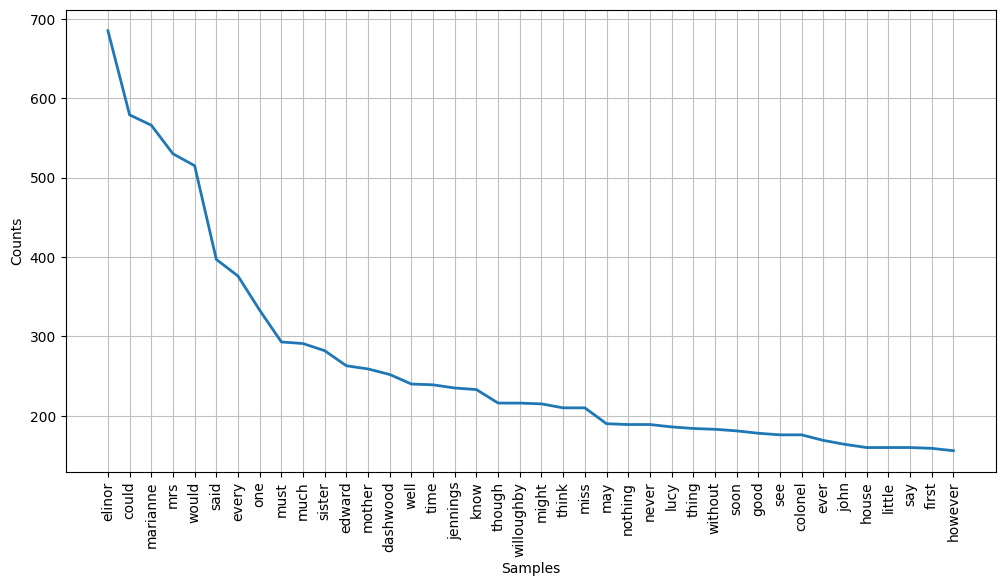

In [9]:
#Visualization of top 40 most common words in text
plt.figure(figsize=(12,6))
fdist.plot(40)
plt.show()

In [10]:
#Initialize Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [15]:
# Perfom Vader sentiment analysis
sentences['compound'] = [analyzer.polarity_scores(x)['compound'] for x in sentences['sentence']]
sentences['neg'] = [analyzer.polarity_scores(x)['neg'] for x in sentences['sentence']]
sentences['neu'] = [analyzer.polarity_scores(x)['neu'] for x in sentences['sentence']]
sentences['pos'] = [analyzer.polarity_scores(x)['pos'] for x in sentences['sentence']]
sentences.head(10)

,sentence,compound,neg,neu,pos
0,"He really pressed them, with some earnestness,...",-0.0258,0.052,0.898,0.050
1,A continuance in a place where everything remi...,0.5994,0.000,0.794,0.206
2,"In seasons of cheerfulness, no temper could be...",0.9117,0.123,0.468,0.409
3,But in sorrow she must be equally carried away...,0.1154,0.145,0.695,0.160
4,Mrs. John Dashwood did not at all approve of w...,0.0000,0.000,1.000,0.000
5,To take three thousand pounds from the fortune...,-0.1513,0.124,0.775,0.101
6,She begged him to think again on the subject.,0.0000,0.000,1.000,0.000
7,How could he answer it to himself to rob his c...,-0.5574,0.159,0.841,0.000
8,And what possible claim could the Miss Dashwoo...,0.1280,0.100,0.814,0.087
9,It was very well known that no affection was e...,-0.2893,0.165,0.691,0.144


In [16]:
#Get number of positive, neutral, and negative sentences
positive_sentence = sentences.loc[sentences['compound'] > 0]
negative_sentence = sentences.loc[sentences['compound'] < 0] 
neutral_sentence = sentences.loc[sentences['compound'] == 0]

print(sentences.shape)
print(len(positive_sentence))
print(len(negative_sentence))
print(len(neutral_sentence))

(5382, 5)
2495
1325
1562


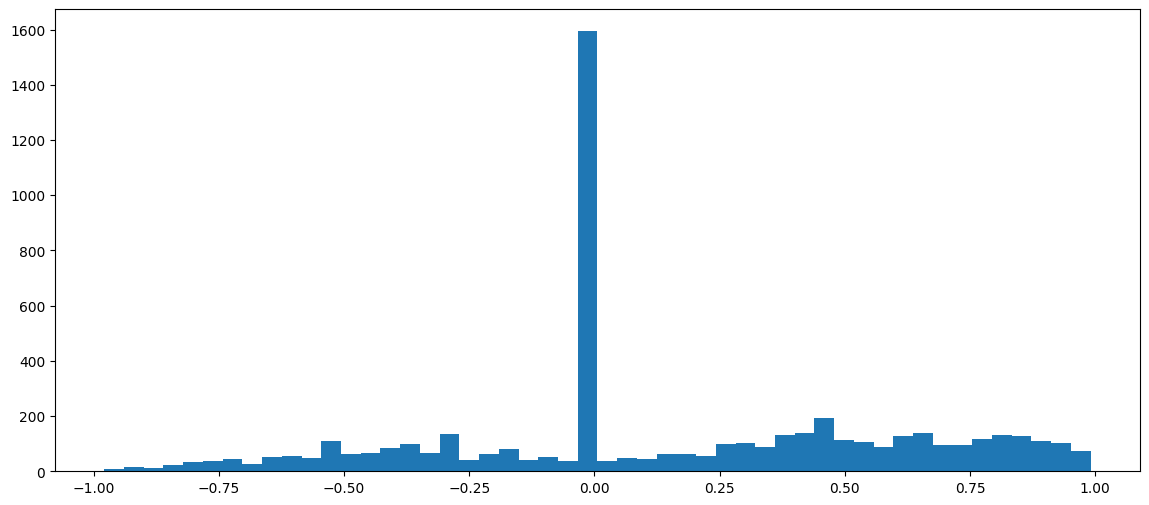

In [13]:
#Visualize Vader sentiment results
plt.figure(figsize=(14,6))
plt.hist(sentences['compound'], bins=50);